# Tennis Action Evaluator

## Introduction

### Problem

### Model Definition

#### State

#### Action

#### Rewards

### Data Processing

#### Raw Data

#### Extracted data

### Evaluation

We evaluate the model based on how well it estimates the actual probability that the agent at state $s$ performing action $a$ will win the rally.

We do this by passing a list of $(s,a)$ pairs to the estimator model to get the $Q(s,a)$ indicating the probability of the agent winning. Each $(s,a)$ pair has already been marked as belonging to the winner or the loser of the rally.

We deem a prediction correct in the following cases:
1. The $(s,a)$ pair belongs to the winner and gives a $Q(s,a) \ge 0.5$ 
2. The $(s,a)$ pair belongs to the loser and gives a $Q(s,a) \lt 0.5$

The final score of the model is calculated using $\frac{\text{correct predictions}}{\text{total predictions}}$.

## Approximated MC Learning

First, we tried a simple approximated MC learning to approximate the $Q(s,a)$ function as a baseline. This is a simple linear regression problem. We used `sklearn.linear_model.LinearRegression` to create an estimator model.

Since the reward of a tennis rally is only non-zero at the end of a rally, MC learning's behavior of looking at the accumulated rewards for an entire trial might be beneficial for estimating the Q-values of tennis actions.

### Training

Being that it is merely solving a system of linear equations, training of the estimator model is very quick for approximated MC learning.

In [1]:
import mc_learning as mc

mc_model = mc.train(save=False)
print(mc_model.coef_)

[[ 0.00046365  0.00620755  0.00934649 -0.02493163  0.0050135  -0.02148365
  -0.00191497 -0.00411411 -0.00643848  0.0220249  -0.00568214  0.02426598
   0.00129729 -0.00062967 -0.02203004  0.00634108 -0.00288176]]


### Evaluation

However, accuracy is low for this method, only correctly predicting the outcome of the $Q(s,a)$ correctly 53% of the time. The $Q(s,a)$ cannot be directly represented by a linear function of the features we have defined.

In [2]:
from data import test_dataset
import evaluation as eval

def mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = mc_model.predict(single_sample_reshape)
    return pred

score = eval.score_model(test_dataset, mc_predict)

print(f"Linear MC Learning Accuracy: {score}")

Linear MC Learning Accuracy: (0.5361596009975063, 0.24950967844844793)


## Deep Reinforcement Learning

### MC

#### Training

In [3]:
import d_sarsa

nn_mc_model, nn_mc_report = d_sarsa.train(save=False, use_mc=True)

EPOCH: 1.000  train_ave_loss: 0.255  train_ave_acc: 0.507  (5.15s - 1025.69s remaining) ave_loss: 0.25465700401763414 ave_acc: 0.5073396494080978
EPOCH: 2.000  train_ave_loss: 0.249  train_ave_acc: 0.524  (8.23s - 814.95s remaining) ave_loss: 0.249360431542844 ave_acc: 0.5244402949409958
EPOCH: 3.000  train_ave_loss: 0.248  train_ave_acc: 0.532  (11.34s - 744.82s remaining) ave_loss: 0.24820993958680163 ave_acc: 0.5317759016406111
EPOCH: 4.000  train_ave_loss: 0.250  train_ave_acc: 0.529  (14.24s - 697.90s remaining) ave_loss: 0.2497156615044015 ave_acc: 0.5287929515070363
EPOCH: 5.000  train_ave_loss: 0.248  train_ave_acc: 0.542  (17.19s - 670.49s remaining) ave_loss: 0.2484428592878353 ave_acc: 0.5415588162428974
EPOCH: 6.000  train_ave_loss: 0.249  train_ave_acc: 0.521  (20.09s - 649.64s remaining) ave_loss: 0.24917829893201676 ave_acc: 0.5212278586389165
EPOCH: 7.000  train_ave_loss: 0.250  train_ave_acc: 0.538  (23.01s - 634.40s remaining) ave_loss: 0.24991052221954743 ave_acc: 0.

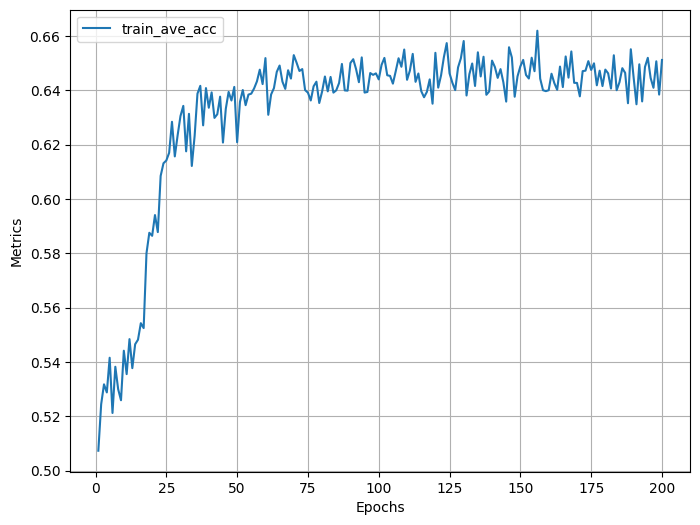

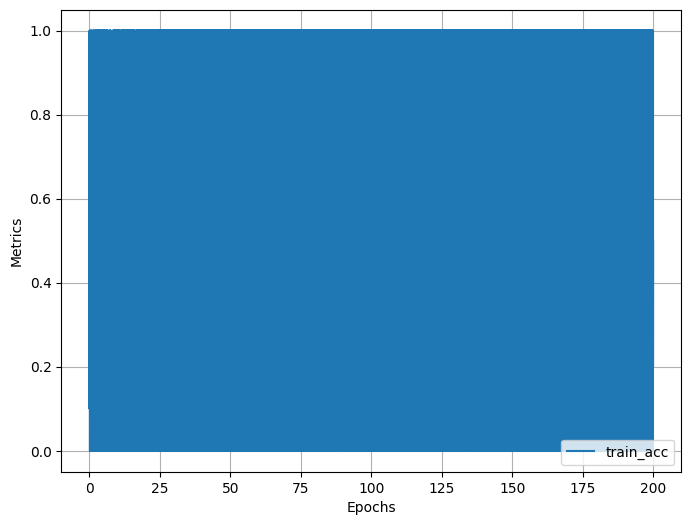

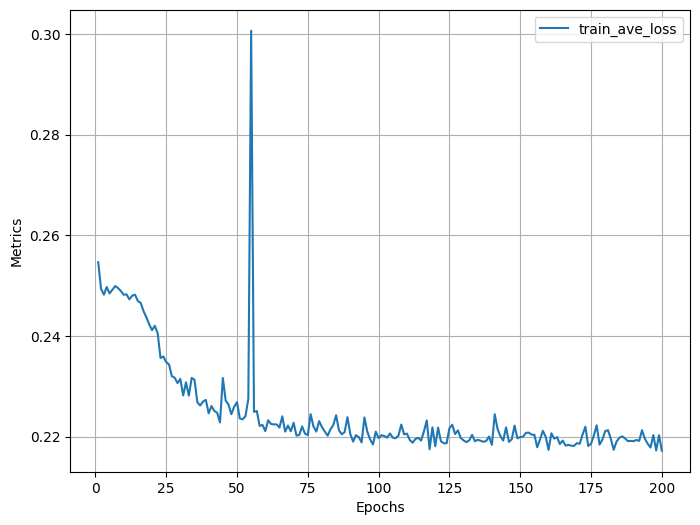

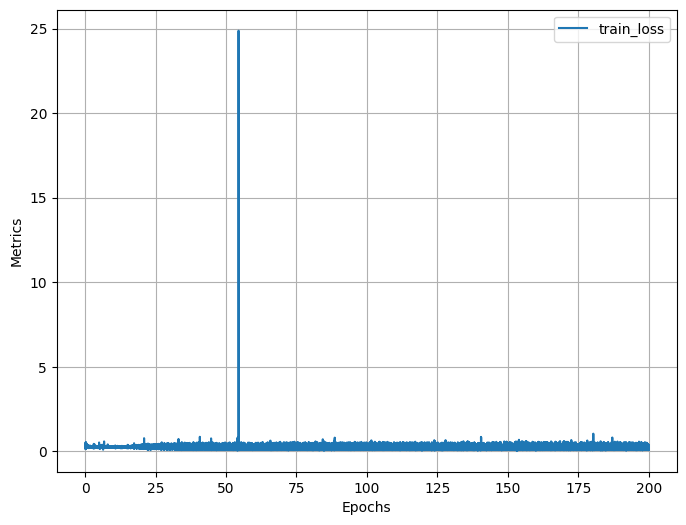

In [4]:
nn_mc_report.plot('train_ave_acc')
nn_mc_report.plot('train_acc')
nn_mc_report.plot('train_ave_loss')
nn_mc_report.plot('train_loss')

#### Evaluation

In [5]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_mc_model.eval()
def nn_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_mc_score, nn_mc_mse = eval.score_model(test_dataset, nn_mc_predict)

def nn_mc_predict_seq(sa_pair_seq):
    pred = nn_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_mc_seq_score, nn_mc_seq_mse = eval.score_model_sequential(test_dataset, nn_mc_predict_seq)

print(f"NN MC Accuracy: {nn_mc_score}")
print(f"NN MC MSE: {nn_mc_mse}")
print(f"NN MC Seq Accuracy: {nn_mc_seq_score}")
print(f"NN MC Seq MSE: {nn_mc_seq_mse}")

NN MC Accuracy: 0.5349127182044888
NN MC MSE: 0.26006584913054354
NN MC Seq Accuracy: 0.5685785536159601
NN MC Seq MSE: 0.2528459779451584


### SARSA

#### Training (Without MC Init)

In [6]:
import d_sarsa

nn_sarsa_model, nn_sarsa_report = d_sarsa.train(save=False, use_mc=False)

EPOCH: 1.000  train_ave_loss: 0.164  train_ave_acc: 0.495  (2.61s - 519.90s remaining) ave_loss: 0.16384809194924718 ave_acc: 0.4951752548526742
EPOCH: 2.000  train_ave_loss: 0.133  train_ave_acc: 0.505  (5.23s - 517.40s remaining) ave_loss: 0.1325468290624512 ave_acc: 0.5049187301097318
EPOCH: 3.000  train_ave_loss: 0.128  train_ave_acc: 0.499  (7.83s - 514.48s remaining) ave_loss: 0.12760939961435858 ave_acc: 0.4986366232333974
EPOCH: 4.000  train_ave_loss: 0.128  train_ave_acc: 0.519  (10.45s - 512.17s remaining) ave_loss: 0.1278873336258347 ave_acc: 0.5188786827550526
EPOCH: 5.000  train_ave_loss: 0.122  train_ave_acc: 0.525  (13.07s - 509.54s remaining) ave_loss: 0.1224572552297035 ave_acc: 0.5252104416660726
EPOCH: 6.000  train_ave_loss: 0.124  train_ave_acc: 0.525  (15.68s - 506.98s remaining) ave_loss: 0.12437975828882711 ave_acc: 0.5253580953910867
EPOCH: 7.000  train_ave_loss: 0.125  train_ave_acc: 0.520  (18.28s - 504.12s remaining) ave_loss: 0.12474850374014497 ave_acc: 0.5

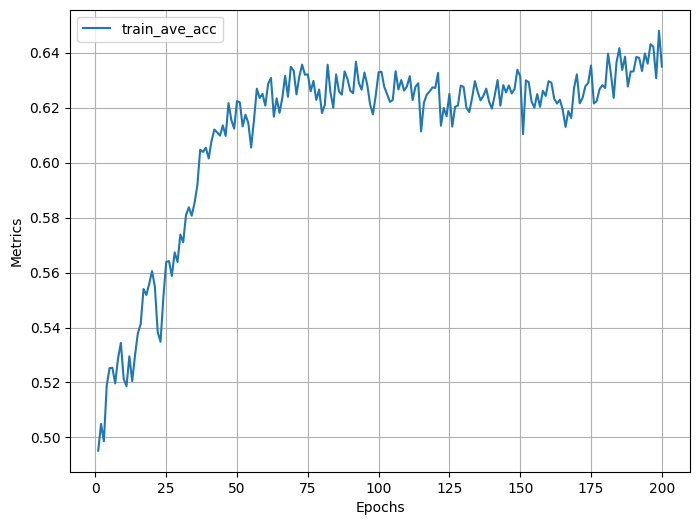

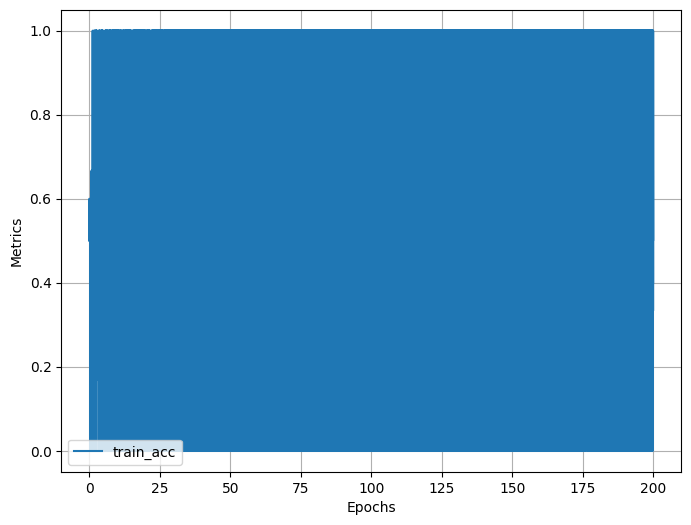

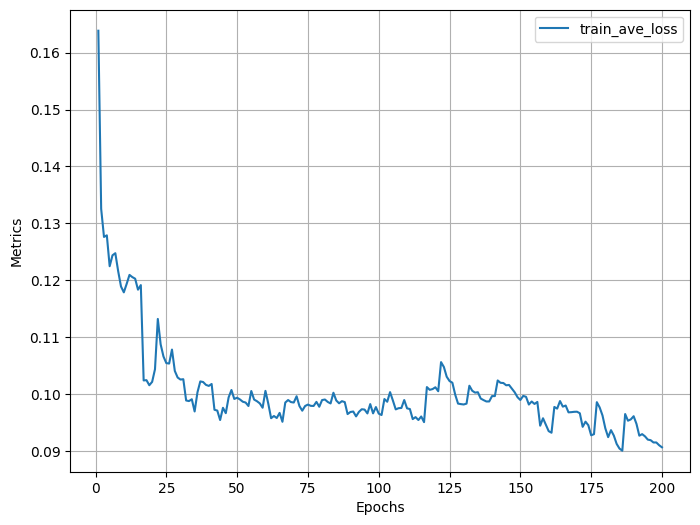

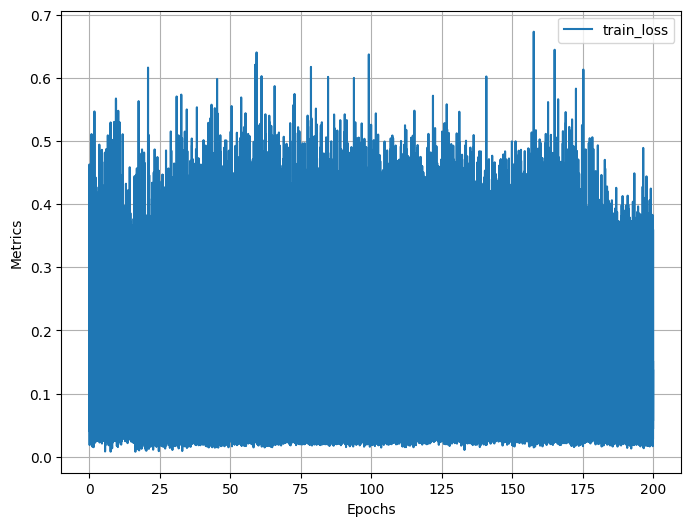

In [7]:
nn_sarsa_report.plot('train_ave_acc')
nn_sarsa_report.plot('train_acc')
nn_sarsa_report.plot('train_ave_loss')
nn_sarsa_report.plot('train_loss')

#### Evaluation (Without MC Init)

In [8]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_sarsa_model.eval()
def nn_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_score, nn_sarsa_mse = eval.score_model(test_dataset, nn_predict)

def nn_predict_seq(sa_pair_seq):
    pred = nn_sarsa_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_seq_score, nn_sarsa_seq_mse = eval.score_model_sequential(test_dataset, nn_predict_seq)

print(f"NN Sarsa Accuracy: {nn_sarsa_score}")
print(f"NN Sarsa MSE: {nn_sarsa_mse}")
print(f"NN Sarsa Seq Accuracy: {nn_sarsa_seq_score}")
print(f"NN Sarsa Seq MSE: {nn_sarsa_seq_mse}")

NN Sarsa Accuracy: 0.5386533665835411
NN Sarsa MSE: 0.24959254880124568
NN Sarsa Seq Accuracy: 0.5324189526184538
NN Sarsa Seq MSE: 0.24845460641871622


#### Training (With MC Init)

In [9]:
import d_sarsa

nn_mc_state_dict = nn_mc_model.state_dict()
nn_sarsa_with_mc_model, nn_sarsa_with_mc_report = d_sarsa.train(save=False, use_mc=False, init_state_dict=nn_mc_state_dict)

Init state dictionary was passed. Using that to initialize model_net.
EPOCH: 1.000  train_ave_loss: 0.099  train_ave_acc: 0.643  (2.64s - 524.81s remaining) ave_loss: 0.09907937556221164 ave_acc: 0.642856449663851
EPOCH: 2.000  train_ave_loss: 0.090  train_ave_acc: 0.637  (5.22s - 516.55s remaining) ave_loss: 0.09048573191542604 ave_acc: 0.6372416089295623
EPOCH: 3.000  train_ave_loss: 0.089  train_ave_acc: 0.634  (7.82s - 513.61s remaining) ave_loss: 0.08945101288985734 ave_acc: 0.6341183297711845
EPOCH: 4.000  train_ave_loss: 0.089  train_ave_acc: 0.648  (10.42s - 510.68s remaining) ave_loss: 0.08907294716915427 ave_acc: 0.6481615786069779
EPOCH: 5.000  train_ave_loss: 0.089  train_ave_acc: 0.640  (13.04s - 508.55s remaining) ave_loss: 0.08878339029564536 ave_acc: 0.6398670826355853
EPOCH: 6.000  train_ave_loss: 0.089  train_ave_acc: 0.635  (15.64s - 505.64s remaining) ave_loss: 0.08927279271600533 ave_acc: 0.6346338139284795
EPOCH: 7.000  train_ave_loss: 0.104  train_ave_acc: 0.631 

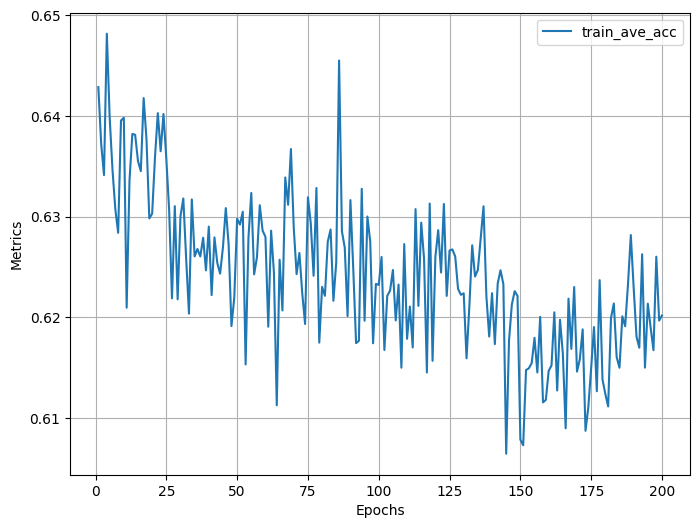

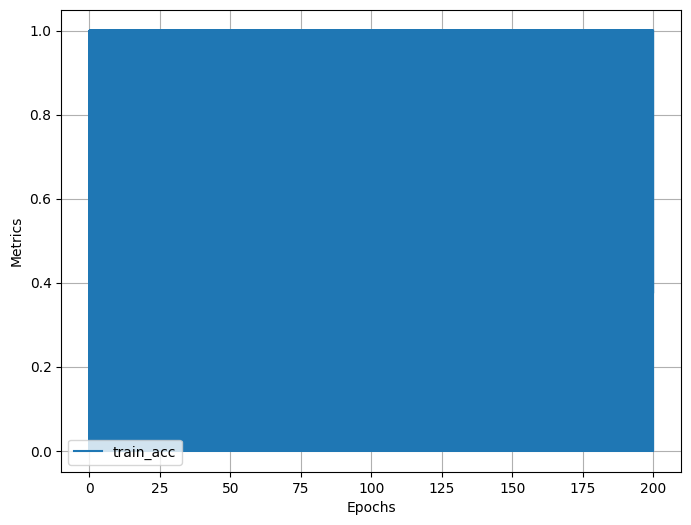

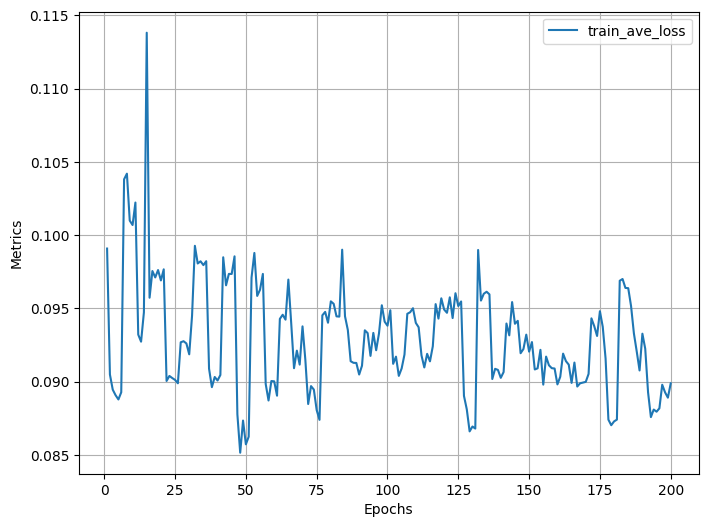

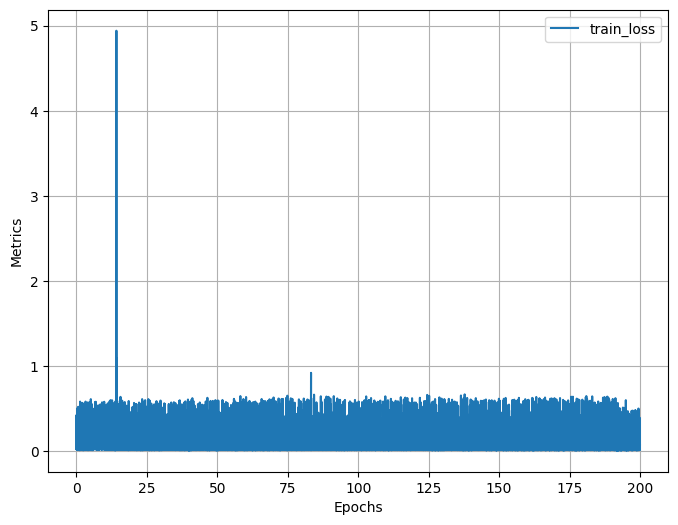

In [10]:
nn_sarsa_with_mc_report.plot('train_ave_acc')
nn_sarsa_with_mc_report.plot('train_acc')
nn_sarsa_with_mc_report.plot('train_ave_loss')
nn_sarsa_with_mc_report.plot('train_loss')

#### Evaluation (With MC Init)

In [11]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_sarsa_with_mc_model.eval()
def nn_sarsa_with_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_with_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_with_mc_score, nn_sarsa_with_mc_mse = eval.score_model(test_dataset, nn_sarsa_with_mc_predict)

def nn_sarsa_with_mc_predict_seq(sa_pair_seq):
    pred = nn_sarsa_with_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_with_mc_seq_score, nn_sarsa_with_mc_seq_mse = eval.score_model_sequential(test_dataset, nn_sarsa_with_mc_predict_seq)

print(f"NN Sarsa With MC Init Accuracy: {nn_sarsa_with_mc_score}")
print(f"NN Sarsa With MC Init MSE: {nn_sarsa_with_mc_mse}")
print(f"NN Sarsa With MC Init Seq Accuracy: {nn_sarsa_with_mc_seq_score}")
print(f"NN Sarsa With MC Init Seq MSE: {nn_sarsa_with_mc_seq_mse}")

NN Sarsa With MC Init Accuracy: 0.5423940149625935
NN Sarsa With MC Init MSE: 0.2539450056161241
NN Sarsa With MC Init Seq Accuracy: 0.543640897755611
NN Sarsa With MC Init Seq MSE: 0.2503242760960259


In [12]:
import os

model_dirpath = 'experiment_models/200epoch_e-3lr_weightdecay_vanilla_paper_params'
os.makedirs(model_dirpath, exist_ok=True)


torch.save(nn_mc_model.state_dict(), os.path.join(model_dirpath, 'nn_mc_model.pth'))
torch.save(nn_sarsa_model.state_dict(), os.path.join(model_dirpath, 'nn_sarsa_model.pth'))
torch.save(nn_sarsa_with_mc_model.state_dict(), os.path.join(model_dirpath, 'nn_sarsa_with_mc_model.pth'))

## Conclusion

### Summary

### Future extensions